In [1]:
import os
import numpy as np
from tqdm import tqdm
from types import SimpleNamespace
from utils import load_test_data, min_max_normalize, recover_targ_loc
from scipy.io import savemat
from utils import combine_idx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from generate_figs.plot_single_act import plot_avgAct_combined


lr = 0.02
correct_only = True
save_plot = True

f_dirs = [
    "test_output_full_model",
    "test_output_noFeedback_model",
    "cutSpec_model",
    "cutNonspec_model",
]

data_dir = "dPCA_allTrial_data"


Initializing Parameters...


In [2]:
f_dir = f_dirs[2]
model_type = f_dir.split("_")[-2]
save_fn_sepStim = os.path.join(
    data_dir, model_type, "sepStim", "all_sepStim_acc.csv"
)
save_fn_sepSac = os.path.join(
    data_dir, model_type, "sepSac", "all_sepSac_acc.csv"
)

all_stim_df = pd.read_csv(save_fn_sepStim)
all_sac_df = pd.read_csv(save_fn_sepSac)

all_sac_df[all_sac_df["total"]<2]

,Unnamed: 0,rep,label,total,acc
35,3,8,right_redL,1,1.0


In [3]:
rep=8
n = SimpleNamespace(
    **load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep))
)
targ_arrange = recover_targ_loc(n.desired_out, n.stim_dir)[-1, :]
y = n.y[:, targ_arrange==1, :]

In [4]:
np.where(y[-1, :, 1] > y[-1, :, 0])

(array([471], dtype=int64),)

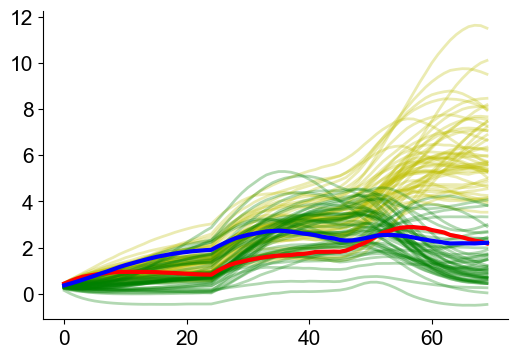

In [5]:
idx = np.random.randint(0, y.shape[1], size=(50,))
plt.plot(y[:, idx, 0], color='y', alpha=0.3)
plt.plot(y[:, idx, 1], color='g', alpha=0.3)

plt.plot(y[:, 471, 0], color='r', linewidth=3)
plt.plot(y[:, 471, 1], color='b', linewidth=3)
plt.show()

In [ ]:

def plot_avgAct_combined(h, n, cell_idx, save_plt, mode, f_dir, m1=True):
    fig, ax = plt.subplots()
    coh_dict = find_coh_idx(n.stim_level)
    H_idx = coh_dict["H"]
    M_idx = coh_dict["M"]
    L_idx = coh_dict["L"]
    Z_idx = coh_dict["Z"]
    red_idx = n.stim_dir == 315
    green_idx = n.stim_dir == 135
    choice_color = get_choice_color(
        n.y, n.desired_out, n.stim_dir
    )  # return choice color (green = 0, red = 1)

    # plot lines
    colors = {
        "H_red": "#FF0000",
        "M_red": "#B30000",
        "L_red": "#660000",
        "H_green": "#00FF00",
        "M_green": "#00B300",
        "L_green": "#006600",
    }
    # zero coherence stimulus direction is based on the choice color
    if mode == "motion":
        if sum(Z_idx) != 0:
            ax.plot(
                np.mean(
                    h[19:, combine_idx(Z_idx, choice_color[-1, :] == 0), cell_idx],
                    axis=1,
                ),
                linestyle="--",
                color="#000000",
                label="135, Z",
            )
            ax.plot(
                np.mean(
                    h[19:, combine_idx(Z_idx, choice_color[-1, :] == 1), cell_idx],
                    axis=1,
                ),
                color="#000000",
                label="315, Z",
            )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, n.correct_idx, green_idx), cell_idx], axis=1
            ),
            color=colors["M_green"],
            label="135, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, n.correct_idx, green_idx), cell_idx], axis=1
            ),
            color=colors["L_green"],
            label="135, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, n.correct_idx, green_idx), cell_idx], axis=1
            ),
            color=colors["H_green"],
            label="135, H",
        )

        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, n.correct_idx, red_idx), cell_idx], axis=1
            ),
            color=colors["L_red"],
            label="315, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, n.correct_idx, red_idx), cell_idx], axis=1
            ),
            color=colors["M_red"],
            label="315, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, n.correct_idx, red_idx), cell_idx], axis=1
            ),
            color=colors["H_red"],
            label="315, H",
        )
    elif mode == "target":
        contra_idx, ipsi_idx = find_sac_idx(n.y, m1)
        if sum(Z_idx) != 0:
            ax.plot(
                np.mean(h[19:, combine_idx(Z_idx, contra_idx), cell_idx], axis=1),
                linestyle="--",
                color="#000000",
                label="contra sac, Z",
            )
            ax.plot(
                np.mean(h[19:, combine_idx(Z_idx, ipsi_idx), cell_idx], axis=1),
                color="#000000",
                label="ipsi sac, Z",
            )
        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, n.correct_idx, contra_idx), cell_idx], axis=1
            ),
            color=colors["L_green"],
            label="contra sac, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, n.correct_idx, contra_idx), cell_idx], axis=1
            ),
            color=colors["M_green"],
            label="contra sac, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, n.correct_idx, contra_idx), cell_idx], axis=1
            ),
            color=colors["H_green"],
            label="contra sac, H",
        )

        ax.plot(
            np.mean(
                h[19:, combine_idx(L_idx, n.correct_idx, ipsi_idx), cell_idx], axis=1
            ),
            color=colors["L_red"],
            label="ipsi sac, L",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(M_idx, n.correct_idx, ipsi_idx), cell_idx], axis=1
            ),
            color=colors["M_red"],
            label="ipsi sac, M",
        )
        ax.plot(
            np.mean(
                h[19:, combine_idx(H_idx, n.correct_idx, ipsi_idx), cell_idx], axis=1
            ),
            color=colors["H_red"],
            label="ipsi sac, H",
        )

    ax.set_xlim(0, 50)
    xticks = np.array([0, 25, 50])
    ax.set_xticks(xticks)
    ax.set_xticklabels((xticks + 20 - stim_st_time) * 20)

    ax.set_title("Cell %d, %s" % (cell_idx, mode))
    ax.set_ylabel("Average activity")
    ax.set_xlabel("Time")
    ax.axvline(x=target_st_time - 20, color="k", alpha=0.8, linestyle="--", linewidth=1)
    ax.axvline(x=stim_st_time - 20, color="k", alpha=0.8, linestyle="--", linewidth=1)
    ax.legend(loc="best", prop={"size": 10}, frameon=False)
    plt.tight_layout()

    if save_plt:
        pic_dir = os.path.join(f_dir, "single_neuron_activity_rep%d_combined" % (rep))
        if not os.path.exists(pic_dir):
            os.makedirs(pic_dir)
        plt.savefig(os.path.join(pic_dir, "cell_%d.png" % cell_idx))
        plt.savefig(os.path.join(pic_dir, "cell_%d.pdf" % cell_idx))
        plt.close(fig)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 994 but corresponding boolean dimension is 2048

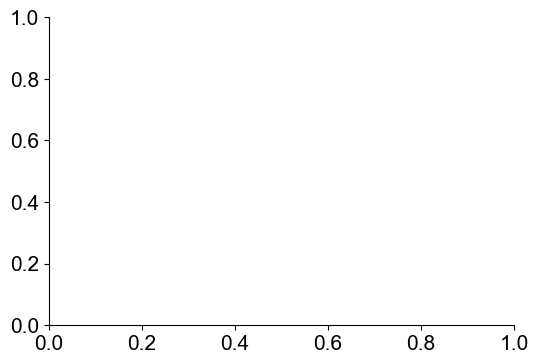

In [6]:
motion_rng = np.concatenate((np.arange(0, 40), np.arange(80, 120), np.arange(160, 170), np.arange(180, 190)), axis=0)
target_rng = np.concatenate((np.arange(40, 80), np.arange(120, 160), np.arange(170, 180), np.arange(190, 200)), axis=0)
plt_dir = os.path.join(f_dir, "rep8_targ_arrange1_single_trial_plot")
for i in motion_rng:
    plot_avgAct_combined(n.h[:, targ_arrange==1, :], n, i, True, mode='motion', f_dir=plt_dir)
for i in target_rng:
    if i in np.concatenate((np.arange(40, 80), np.arange(170, 180))):
        plot_avgAct_combined(n.h[:, targ_arrange==1, :], n, i, True, mode='target', f_dir=plt_dir,  m1=True)
    else:
        plot_avgAct_combined(n.h[:, targ_arrange==1, :], n, i, True, mode='target', f_dir=plt_dir,m1=False)